# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times (or more precisely the moving times) for hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import h5py

import gpxStats
import utils

print(tf.__version__)

2.2.0


### Load data
Load the dataset that was prepared by running `prepareData.py`.

In [2]:
# run prepareData.py '~/GPX-Tracks' 'Wandern'

In [3]:
train_dataset_file = 'hiking_data_training.hdf5'
test_dataset_file = 'hiking_data_test.hdf5'

Convert data to a pandas dataframe:

In [4]:
def read_hdf5_to_dict(file_name):
    hdf5_data = h5py.File(file_name, 'r')
    hdf5_data_dict = {}
    for name in gpxStats.GpxSegmentStats.getHeader():
        if name == 'Path':
            hdf5_data_dict[name] = [gpxStats.PathFeature(data) for data in hdf5_data[name]]
        else:
            hdf5_data_dict[name] = hdf5_data[name][...]

    hdf5_data.close()
    return hdf5_data_dict

train_hdf5_data_dict = read_hdf5_to_dict(train_dataset_file)
test_hdf5_data_dict = read_hdf5_to_dict(test_dataset_file)

path_features_shape = train_hdf5_data_dict['Path'][0].shape
    
train_dataset = pd.DataFrame.from_dict(train_hdf5_data_dict)
test_dataset = pd.DataFrame.from_dict(test_hdf5_data_dict)

train_dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill,Path
5418,52.264453,53.381755,58.0,58.0,0.0,0.000000,10.733358,<gpxStats.PathFeature object at 0x7f049d497a90>
5419,91.418732,93.330839,108.0,108.0,0.0,0.000000,17.266683,<gpxStats.PathFeature object at 0x7f049d497ac8>
5420,53.690754,54.113753,52.0,52.0,0.0,5.533285,0.000000,<gpxStats.PathFeature object at 0x7f049d497b00>
5421,52.206475,52.522497,41.0,41.0,0.0,5.733317,0.000000,<gpxStats.PathFeature object at 0x7f049d497b38>
5422,70.170335,70.517933,68.0,68.0,0.0,0.000000,6.733358,<gpxStats.PathFeature object at 0x7f049d497b70>


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

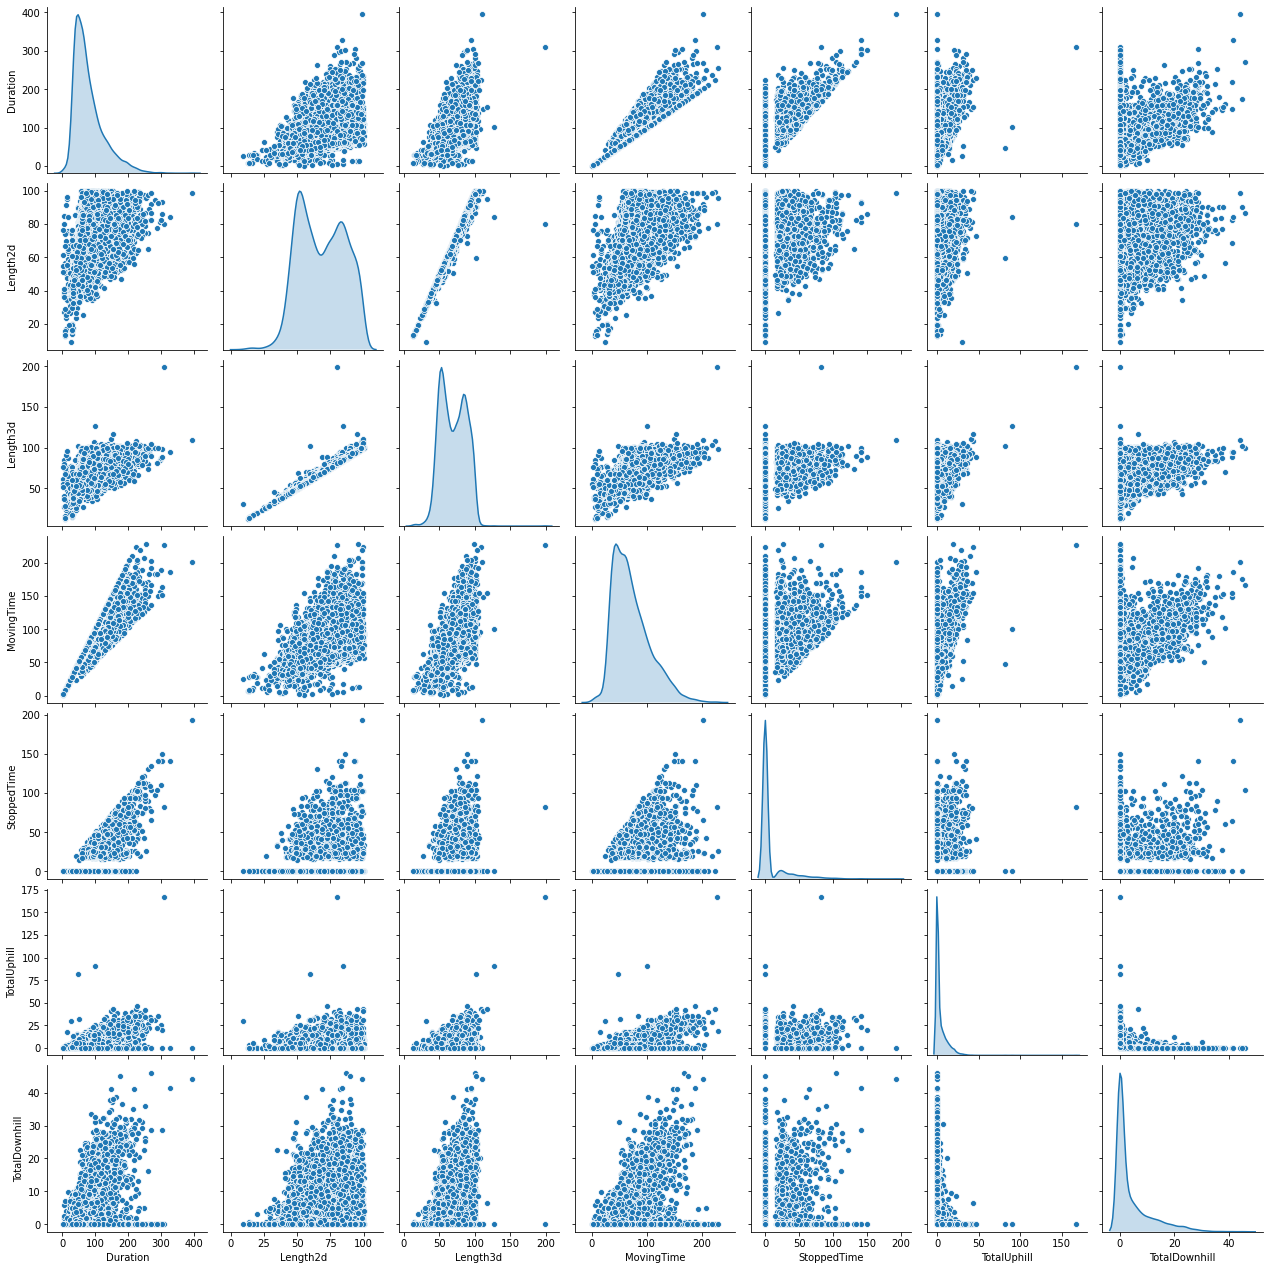

In [5]:
sns.pairplot(train_dataset[["Duration", "Length2d", "Length3d", "MovingTime", "StoppedTime", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

Also look at the overall statistics:

In [6]:
train_dataset_stats = train_dataset.describe()
train_dataset_stats.pop("MovingTime")
train_dataset_stats.pop("StoppedTime")
train_dataset_stats.pop("Duration")
train_dataset_stats = train_dataset_stats.transpose()
train_dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,5423.0,68.538888,17.220305,9.041167,53.476650,67.972200,83.300763,99.993868
Length3d,5423.0,69.628014,17.710744,12.903817,54.207306,69.118418,84.838200,198.873195
TotalUphill,5423.0,4.175006,7.131460,0.000000,0.000000,0.606669,5.933309,167.666667
TotalDownhill,5423.0,4.404140,6.881208,0.000000,0.000000,0.680013,6.276656,46.000081


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [7]:
label_columns = ['MovingTime', 'StoppedTime', 'Duration']
train_labels_data = []
test_labels_data = []

for col_name in label_columns:
    train_labels_data.append(train_dataset.pop(col_name))
    test_labels_data.append(test_dataset.pop(col_name))

train_labels = pd.concat(train_labels_data, axis=1)
train_labels.sort_index(inplace=True)
test_labels = pd.concat(test_labels_data, axis=1)
test_labels.sort_index(inplace=True)

### Normalize the data

The statistics about `train_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset and the pretraining data set. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [16]:
def norm(x):
    return (x - train_dataset_stats['mean']) / train_dataset_stats['std']

def convert_paths_to_array(path_features):
    return np.array([path_data.data for path_data in path_features])

train_paths = train_dataset.pop('Path')
normed_train_data = norm(train_dataset)

test_paths = test_dataset.pop('Path')
normed_test_data = norm(test_dataset)

train_paths_as_array = convert_paths_to_array(train_paths)
test_paths_as_array = convert_paths_to_array(test_paths)

with open('train_dataset_stats.csv', 'w') as csvfile:
    train_dataset_stats.to_csv(csvfile, sep=' ')

`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, for convencience.

In [19]:
learning_rate = 0.001

def build_model():
    stat_inputs = layers.Input(shape=(normed_train_data.shape[1],), name='StatInput')
    stat_dense1 = layers.Dense(16, activation=tf.nn.relu)(stat_inputs)
    stat_dense2 = layers.Dense(16, activation=tf.nn.relu)(stat_dense1)
    stat_dense3 = layers.Dense(16, activation=tf.nn.relu)(stat_dense2)
    stat_dense4 = layers.Dense(16, activation=tf.nn.relu)(stat_dense3)
    
    path_inputs = layers.Input(shape=path_features_shape, name='PathInputs')
    conv1 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(path_inputs)
    conv2 = layers.Conv1D(filters=12, kernel_size=3, padding='same', activation=tf.nn.relu)(conv1)
    bn1 = layers.BatchNormalization()(conv2)
    conv3 = layers.Conv1D(filters=24, kernel_size=3, padding='same', activation=tf.nn.relu)(bn1)
    conv4 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(conv3)
    bn2 = layers.BatchNormalization()(conv4)
    
    lstm1 = layers.LSTM(16, return_sequences=True)(bn2)
    dropout = layers.Dropout(0.25)(lstm1)
    lstm2 = layers.LSTM(16, return_sequences=False)(dropout)
    dropout2 = layers.Dropout(0.25)(lstm2)
    lstm_dense1 = layers.Dense(16, activation=tf.nn.relu)(dropout2)
    
    concat = layers.Concatenate()([stat_dense4, lstm_dense1])
    dense1 = layers.Dense(32, activation=tf.nn.relu)(concat)
    dense2 = layers.Dense(32, activation=tf.nn.relu)(dense1)
    
    outputs = layers.Dense(len(train_labels.keys()), activation=None)(dense2)
    
    model = models.Model(inputs=[stat_inputs, path_inputs], outputs=outputs)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
PathInputs (InputLayer)         [(None, 25, 3)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 25, 6)        60          PathInputs[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 25, 12)       228         conv1d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 12)       48          conv1d_5[0][0]                   
____________________________________________________________________________________________


Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [21]:
example_batch = [normed_train_data[:4], train_paths_as_array[:4]]
example_result = model.predict(example_batch)
example_result

array([[-0.11108507,  0.00647549,  0.06051297],
       [-0.11235957,  0.00655068,  0.05915995],
       [-0.11249378,  0.00655301,  0.0593453 ],
       [-0.11244252,  0.00648481,  0.05950159]], dtype=float32)

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [22]:
EPOCHS = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=10, min_lr=0.01*learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                                                  restore_best_weights=True)

callbacks = [reduce_lr, early_stopping]


history = model.fit([normed_train_data, train_paths_as_array], 
                    train_labels.values,
                    epochs=EPOCHS, validation_split=0.2, verbose=1,
                    callbacks=callbacks)

Epoch 1/500
136/136 [==============================] - 3s 23ms/step - loss: 2636.7603 - mean_absolute_error: 35.1550 - mean_squared_error: 2636.7603 - val_loss: 835.5107 - val_mean_absolute_error: 20.1235 - val_mean_squared_error: 835.5107 - lr: 0.0010
Epoch 2/500
136/136 [==============================] - 2s 18ms/step - loss: 648.4883 - mean_absolute_error: 17.6808 - mean_squared_error: 648.4883 - val_loss: 2953.4390 - val_mean_absolute_error: 44.9571 - val_mean_squared_error: 2953.4390 - lr: 0.0010
Epoch 3/500
136/136 [==============================] - 2s 18ms/step - loss: 570.4099 - mean_absolute_error: 16.4599 - mean_squared_error: 570.4099 - val_loss: 2999.2390 - val_mean_absolute_error: 46.7539 - val_mean_squared_error: 2999.2390 - lr: 0.0010
Epoch 4/500
136/136 [==============================] - 3s 18ms/step - loss: 535.0955 - mean_absolute_error: 15.8949 - mean_squared_error: 535.0955 - val_loss: 1643.4529 - val_mean_absolute_error: 34.5591 - val_mean_squared_error: 1643.4529 -

136/136 [==============================] - 3s 19ms/step - loss: 444.0482 - mean_absolute_error: 13.7471 - mean_squared_error: 444.0482 - val_loss: 856.5196 - val_mean_absolute_error: 23.9236 - val_mean_squared_error: 856.5196 - lr: 0.0010
Epoch 34/500
136/136 [==============================] - 3s 19ms/step - loss: 462.5749 - mean_absolute_error: 13.9459 - mean_squared_error: 462.5749 - val_loss: 455.6318 - val_mean_absolute_error: 14.0620 - val_mean_squared_error: 455.6318 - lr: 0.0010
Epoch 35/500
136/136 [==============================] - 3s 20ms/step - loss: 441.0622 - mean_absolute_error: 13.7013 - mean_squared_error: 441.0622 - val_loss: 1429.2985 - val_mean_absolute_error: 31.3627 - val_mean_squared_error: 1429.2985 - lr: 0.0010
Epoch 36/500
136/136 [==============================] - 3s 20ms/step - loss: 449.0507 - mean_absolute_error: 13.6842 - mean_squared_error: 449.0507 - val_loss: 528.3786 - val_mean_absolute_error: 13.6306 - val_mean_squared_error: 528.3786 - lr: 0.0010
Epo

136/136 [==============================] - 3s 19ms/step - loss: 404.6327 - mean_absolute_error: 12.9989 - mean_squared_error: 404.6327 - val_loss: 440.3403 - val_mean_absolute_error: 13.0966 - val_mean_squared_error: 440.3403 - lr: 5.0000e-04
Epoch 66/500
136/136 [==============================] - 3s 20ms/step - loss: 410.2266 - mean_absolute_error: 13.0486 - mean_squared_error: 410.2266 - val_loss: 439.1084 - val_mean_absolute_error: 13.1410 - val_mean_squared_error: 439.1084 - lr: 5.0000e-04
Epoch 67/500
136/136 [==============================] - 3s 19ms/step - loss: 403.2786 - mean_absolute_error: 12.9738 - mean_squared_error: 403.2786 - val_loss: 435.1117 - val_mean_absolute_error: 12.7557 - val_mean_squared_error: 435.1117 - lr: 5.0000e-04
Epoch 68/500
136/136 [==============================] - 3s 19ms/step - loss: 406.6039 - mean_absolute_error: 12.9783 - mean_squared_error: 406.6039 - val_loss: 432.4190 - val_mean_absolute_error: 13.3459 - val_mean_squared_error: 432.4190 - lr: 

136/136 [==============================] - 3s 20ms/step - loss: 390.0789 - mean_absolute_error: 12.7149 - mean_squared_error: 390.0789 - val_loss: 427.7735 - val_mean_absolute_error: 13.3292 - val_mean_squared_error: 427.7735 - lr: 2.5000e-04
Epoch 98/500
136/136 [==============================] - 3s 21ms/step - loss: 382.5452 - mean_absolute_error: 12.6084 - mean_squared_error: 382.5452 - val_loss: 428.5132 - val_mean_absolute_error: 12.9126 - val_mean_squared_error: 428.5132 - lr: 2.5000e-04
Epoch 99/500
136/136 [==============================] - 3s 19ms/step - loss: 379.9184 - mean_absolute_error: 12.5975 - mean_squared_error: 379.9184 - val_loss: 430.3197 - val_mean_absolute_error: 12.6442 - val_mean_squared_error: 430.3197 - lr: 2.5000e-04
Epoch 100/500
136/136 [==============================] - 3s 19ms/step - loss: 384.5999 - mean_absolute_error: 12.6013 - mean_squared_error: 384.5999 - val_loss: 448.9036 - val_mean_absolute_error: 13.8503 - val_mean_squared_error: 448.9036 - lr:

Epoch 129/500
136/136 [==============================] - 3s 19ms/step - loss: 371.8514 - mean_absolute_error: 12.3669 - mean_squared_error: 371.8514 - val_loss: 433.3640 - val_mean_absolute_error: 12.6613 - val_mean_squared_error: 433.3640 - lr: 6.2500e-05
Epoch 130/500
136/136 [==============================] - 3s 19ms/step - loss: 370.5018 - mean_absolute_error: 12.3633 - mean_squared_error: 370.5018 - val_loss: 427.4778 - val_mean_absolute_error: 12.6196 - val_mean_squared_error: 427.4778 - lr: 6.2500e-05
Epoch 131/500
136/136 [==============================] - 3s 19ms/step - loss: 373.6046 - mean_absolute_error: 12.4163 - mean_squared_error: 373.6046 - val_loss: 428.5360 - val_mean_absolute_error: 12.8388 - val_mean_squared_error: 428.5360 - lr: 6.2500e-05
Epoch 132/500
136/136 [==============================] - 3s 19ms/step - loss: 375.7877 - mean_absolute_error: 12.4174 - mean_squared_error: 375.7877 - val_loss: 427.3680 - val_mean_absolute_error: 12.8600 - val_mean_squared_error

Visualize the model's training progress using the stats stored in the `history` object.

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
143,370.524231,12.386798,370.524231,428.025238,12.703421,428.025238,0.000031,143
144,368.733093,12.349447,368.733093,426.830963,12.777466,426.830963,0.000031,144
145,374.345856,12.449116,374.345856,428.409851,12.794010,428.409851,0.000031,145
146,373.057983,12.427558,373.057983,429.111053,12.708720,429.111053,0.000031,146
147,369.370667,12.359221,369.370667,426.853546,12.799479,426.853546,0.000031,147


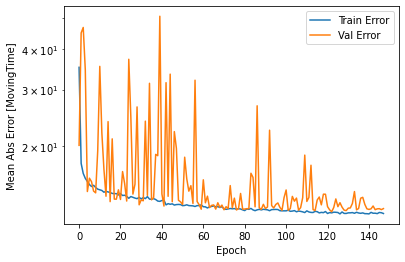

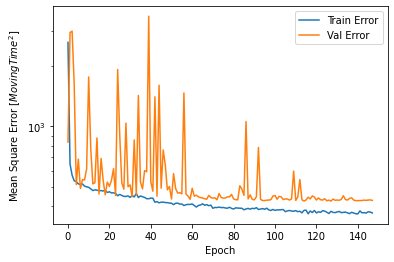

In [24]:
utils.plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

In [25]:
compute_standard_walking_time_vectorized = np.vectorize(utils.compute_standard_walking_time)

standard_estimate_walking_time = compute_standard_walking_time_vectorized(test_dataset['Length2d'].values,
                                                                          test_dataset['TotalUphill'].values,
                                                                          test_dataset['TotalDownhill'].values)

In [27]:
moving_stopped_duration_data_list = []
for index, data in test_labels.iterrows():
    moving_stopped_duration_data_list.append([data['MovingTime'], data['StoppedTime'], data['Duration']])
moving_stopped_duration_data = np.array(moving_stopped_duration_data_list)
moving_stopped_duration_data = np.transpose(moving_stopped_duration_data)


test_predictions = np.transpose(model.predict([normed_test_data, test_paths_as_array]))

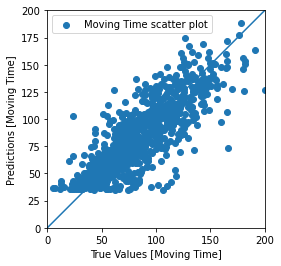

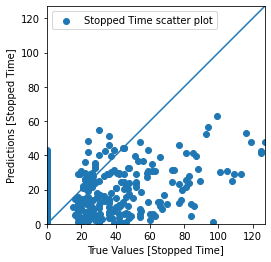

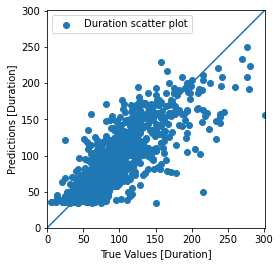

In [28]:
label_texts = ['Moving Time', 'Stopped Time', 'Duration']
    
for i in range(3):
    utils.scatter_plot(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

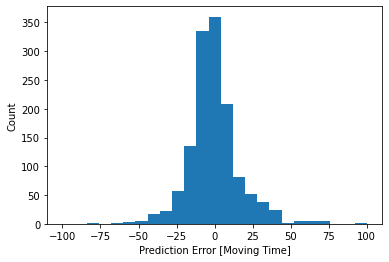

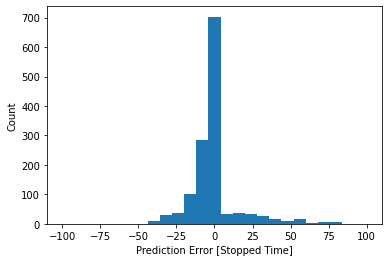

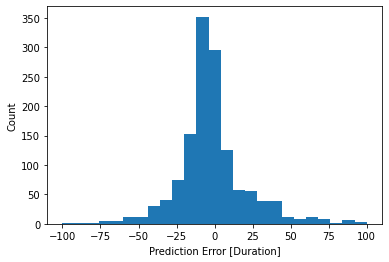

In [29]:
for i in range(3):
    utils.plot_error_hist(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It's not quite gaussian, but we might expect that because the number of samples is very small.

Export model for use in inference:

In [30]:
model.save('model_hikingTimePrediction_mixed.h5')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem.